If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [1]:
!pip install datasets transformers

Note: you may need to restart the kernel to use updated packages.


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [5]:
!pip install ipywidgets

     |████████████████████████████████| 123 kB 9.5 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 1.6 MB 8.7 MB/s eta 0:00:01     |██████████████████████▏         | 1.1 MB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 245 kB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 4.0 MB/s eta 0:00:011
     |████████████████████████████████| 9.9 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 4.6 MB/s eta 0:00:011
     |████████████████████████████████| 561 kB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 8.8 MB/s eta 0:00:01
  Using cached zipp-3.8.0-py3-none-any.whl (5.4 kB)
     |████████████████████████████████| 86 kB 3.9 MB/s  eta 0:00:01
     |████████████████████████████████| 71 kB 155 kB/s  eta 0:00:01
     |████████████████████████████████| 128 kB 9.1 MB/s eta 0:00

In [1]:
from huggingface_hub import notebook_login

notebook_login()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Then you need to install Git-LFS. Uncomment the following instructions:

In [ ]:
# !apt install git-lfs

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [2]:
import transformers

print(transformers.__version__)

4.19.4


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/question-answering).

# Fine-tuning a model on a question-answering task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a question answering task, which is the task of extracting the answer to a question from a given context. We will see how to easily load a dataset for these kinds of tasks and use the `Trainer` API to fine-tune a model on it.

![Widget inference representing the QA task](https://github.com/huggingface/notebooks/blob/main/examples/images/question_answering.png?raw=1)

**Note:** This notebook finetunes models that answer question by taking a substring of a context, not by generating new text.

This notebook is built to run on any question answering task with the same format as SQUAD (version 1 or 2), with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a token classification head and a fast tokenizer (check on [this table](https://huggingface.co/transformers/index.html#bigtable) if this is the case). It might just need some small adjustments if you decide to use a different dataset than the one used here. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [7]:
# This flag is the difference between SQUAD v1 or 2 (if you're using another dataset, it indicates if impossible
# answers are allowed or not).
squad_v2 = False
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [8]:
from datasets import load_dataset, load_metric

For our example here, we'll use the [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/). The notebook should work with any question answering dataset provided by the 🤗 Datasets library. If you're using your own dataset defined from a JSON or csv file (see the [Datasets documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) on how to load them), it might need some adjustments in the names of the columns used.

In [9]:
loaded_dataset = load_dataset("squad_v2" if squad_v2 else "squad")

Reusing dataset squad (/home/user/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
loaded_dataset['train'][1]

{'id': '5733be284776f4190066117f',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'What is in front of the Notre Dame Main Building?',
 'answers': {'text': ['a copper statue of Christ'], 'answer_start': [188]}}

In [11]:
import json
import pandas as pd
import uuid
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset
import datasets

with open('./datasets/adv_para.json', 'r') as f:
    json_data = json.load(f)


dic_data = json_data['data']
par_datas = []
uuids = []

for i in range(len(dic_data)):
    uuids.append(uuid.uuid4().hex[:24])


for idx, data in enumerate(dic_data):
    dic = {}
    dic['id'] = uuids[idx]
    dic['title'] = data['title']
    dic['context'] = dic_data[idx]['paragraphs'][0]['context']
    dic['question'] = dic_data[idx]['paragraphs'][0]['qas'][0]['question']

    text = []
    answer = []
    for txt_answer in dic_data[idx]['paragraphs'][0]['qas'][0]['answers']:
        text.append(txt_answer['text'])
        answer.append(txt_answer['answer_start'])

    for txt_answer in dic_data[idx]['paragraphs'][0]['qas'][0]['answers']:
        if txt_answer['text'] in dic['context']:
            break
    
    answers = {}
    answers['text'] = text
    answers['answer_start'] = answer

    dic['answers'] = answers
    par_datas.append(dic)



In [12]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset
import datasets

df = pd.DataFrame(par_datas)
dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())

# convert to Huggingface dataset
par_datas = Dataset(pa.Table.from_pandas(df))

par_datasets = datasets.DatasetDict({"train": loaded_dataset['train'], "validation": par_datas})
par_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 56
    })
})

In [66]:
with open('./datasets/adv_orig.json', 'r') as f:
    json_data = json.load(f)


dic_data = json_data['data']
orig_datas = []
uuids = []

for i in range(len(dic_data)):
    uuids.append(uuid.uuid4().hex[:24])


for idx, data in enumerate(dic_data):
    dic = {}
    dic['id'] = uuids[idx]
    dic['title'] = data['title']
    dic['context'] = dic_data[idx]['paragraphs'][0]['context']
    dic['question'] = dic_data[idx]['paragraphs'][0]['qas'][0]['question']

    text = []
    answer = []
    for txt_answer in dic_data[idx]['paragraphs'][0]['qas'][0]['answers']:
        text.append(txt_answer['text'])
        answer.append(txt_answer['answer_start'])

    for txt_answer in dic_data[idx]['paragraphs'][0]['qas'][0]['answers']:
        if txt_answer['text'] in dic['context']:
            break
    
    answers = {}
    answers['text'] = text
    answers['answer_start'] = answer

    dic['answers'] = answers
    orig_datas.append(dic)

df = pd.DataFrame(orig_datas)
dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())

# convert to Huggingface dataset
orig_datas = Dataset(pa.Table.from_pandas(df))

orig_datasets = datasets.DatasetDict({"train": loaded_dataset['train'], "validation": orig_datas})
orig_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 56
    })
})

In [76]:
print(par_datasets['validation'][7])
print()
print(orig_datasets['validation'][7])

{'id': '72874d16117c4381b3616e83', 'title': 'Title_7', 'context': 'The IPCC Panel is composed of representatives appointed by governments and organizations. Participation of delegates with appropriate expertise is encouraged. Plenary sessions of the IPCC and IPCC Working groups are held at the level of government representatives. Non Governmental and Intergovernmental Organizations may be allowed to attend as observers. Sessions of the IPCC Bureau, workshops, expert and lead authors meetings are by invitation only. Attendance at the 2003 meeting included 350 government officials and climate change experts. After the opening ceremonies, closed plenary sessions were held. The meeting report states there were 322 persons in attendance at Sessions with about seven-eighths of participants being from governmental organizations.', 'question': 'How many persons are in attendance at the 2003 IPCC meeting?', 'answers': {'answer_start': [494, 494, 494], 'text': ['350', '350', '350']}}

{'id': '96

The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [13]:
loaded_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [14]:
par_datasets["validation"][2]

{'id': 'c6cd4d3133024b32b9898199',
 'title': 'Title_2',
 'context': 'During his second year of study at Graz, Tesla developed a passion for (and became very proficient at) billiards, chess and card-playing, sometimes spending more than 48 hours in a stretch at a gaming table.:43, 301 On one occasion at his laboratory, Tesla worked for a period of 84 hours without sleep or rest.:208 Kenneth Swezey, a journalist whom Tesla had befriended, confirmed that Tesla rarely slept. Swezey recalled one morning when Tesla called him at 3 a.m.: "I was sleeping in my room like one dead ... Suddenly, the telephone ring awakened me ... [Tesla] spoke animatedly, with pauses, [as he] ... work[ed] out a problem, comparing one theory to another, commenting; and when he felt he had arrived at the solution, he suddenly closed the telephone."',
 'question': 'How long would Tesla spend gambling sometimes without sleep or rest?',
 'answers': {'answer_start': [157, 167, 167],
  'text': ['more than 48 hours', '48

We can see the answers are indicated by their start position in the text (here at character 515) and their full text, which is a substring of the context as we mentioned above.

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [15]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [16]:
show_random_elements(par_datasets["train"])

## Preprocessing the training data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [17]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

In [18]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

You can check which type of models have a fast tokenizer available and which don't on the [big table of models](https://huggingface.co/transformers/index.html#bigtable).

You can directly call this tokenizer on two sentences (one for the answer, one for the context):

In [19]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 25353, 22144, 2378, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

Now one specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`:

In [20]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

Let's find one long example in our dataset:

In [21]:
#for i, example in enumerate(datasets["train"]):
for i, example in enumerate(par_datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = par_datasets['train'][i]

Without any truncation, we get the following length for the input IDs:

In [22]:
len(tokenizer(example["question"], example["context"])["input_ids"])

396

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [23]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

Note that we never want to truncate the question, only the context, else the `only_second` truncation picked. Now, our tokenizer can automatically return us a list of features capped by a certain maximum length, with the overlap we talked above, we just have to tell it with `return_overflowing_tokens=True` and by passing the stride:

In [24]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

Now we don't have one list of `input_ids`, but several: 

In [25]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 157]

And if we decode them, we can see the overlap:

In [26]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] how many wins does the notre dame men's basketball team have? [SEP] the men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 ncaa tournaments. former player austin carr holds the record for most points scored in a single game of the tournament with 61. although the team has never won the ncaa tournament, they were named by the helms athletic foundation as national champions twice. the team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending ucla's record 88 - game winning streak in 1974. the team has beaten an additional eight number - one teams, and those nine wins rank second, to ucla's 10, all - time in wins against the top team. the team plays in newly renovated purcell pavilion ( within the edmund p. joyce center ), which reopened for the beginning of the 2009 – 2010 season. the team is coached by mike brey, who, as of the 2014 – 15 season, his fifteenth at notr

Now this will give us some work to properly treat the answers: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an `offset_mapping`:

In [27]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (36, 37), (37, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364, 373), (374,

This gives, for each index of our input IDS, the corresponding start and end character in the original text that gave our token. The very first token (`[CLS]`) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question:

In [28]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

how How


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [29]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

In [30]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

23 26


And we can double check that it is indeed the theoretical answer:

In [31]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

over 1, 600
over 1,600


For this notebook to work with any kind of models, we need to account for the special case where the model expects padding on the left (in which case we switch the order of the question and the context):

In [32]:
pad_on_right = tokenizer.padding_side == "right"

Now let's put everything together in one function we will apply to our training set. In the case of impossible answers (the answer is in another feature given by an example with a long context), we set the cls index for both the start and end position. We could also simply discard those examples from the training set if the flag `allow_impossible_answers` is `False`. Since the preprocessing is already complex enough as it is, we've kept is simple for this part.

In [33]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        #print("input id", input_ids, "cls_index", cls_index)
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [34]:
features = prepare_train_features(par_datasets['train'][:5])

In [35]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        #print("input id", input_ids, "cls_index", cls_index)
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command. Since our preprocessing changes the number of samples, we need to remove the old columns when applying it.

In [36]:
tokenized_datasets = par_datasets.map(prepare_train_features, batched=True, remove_columns=par_datasets['train'].column_names)

Loading cached processed dataset at /home/user/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-f7116d0ab92c4731.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

In [37]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 88524
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 56
    })
})

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready for training, we can download the pretrained model and fine-tune it. Since our task is question answering, we use the `AutoModelForQuestionAnswering` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us:

In [38]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

#model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained('test-squad-trained', local_files_only=True)

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [39]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-squad"` or `"huggingface/bert-finetuned-squad"`).

Then we will need a data collator that will batch our processed examples together, here the default one will work:

In [40]:
from transformers import default_data_collator

data_collator = default_data_collator

We will evaluate our model and compute metrics in the next section (this is a very long operation, so we will only compute the evaluation loss during training).

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [41]:
len(tokenized_datasets["train"])

88524

In [42]:
'''
import random

num_task = 5
total_indexes = [i for i in range(len(tokenized_datasets["train"]))]
task_indexes = []
random.shuffle(total_indexes)
index_per_task = len(total_indexes)//num_task

for i in range(num_task):
    if i != num_task - 1:
        task_indexes.append(total_indexes[index_per_task*i:index_per_task*(i+1)])
    else:
        task_indexes.append(total_indexes[index_per_task*i:])

task_datas = []
array_datasets = np.array(tokenized_datasets["train"])
for index in task_indexes:
    task_datas.append(array_datasets[index])
'''

'\nimport random\n\nnum_task = 5\ntotal_indexes = [i for i in range(len(tokenized_datasets["train"]))]\ntask_indexes = []\nrandom.shuffle(total_indexes)\nindex_per_task = len(total_indexes)//num_task\n\nfor i in range(num_task):\n    if i != num_task - 1:\n        task_indexes.append(total_indexes[index_per_task*i:index_per_task*(i+1)])\n    else:\n        task_indexes.append(total_indexes[index_per_task*i:])\n\ntask_datas = []\narray_datasets = np.array(tokenized_datasets["train"])\nfor index in task_indexes:\n    task_datas.append(array_datasets[index])\n'

In [43]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/user/Desktop/smh/bigdata/distilbert-base-uncased-finetuned-squad is already a clone of https://huggingface.co/seomh/distilbert-base-uncased-finetuned-squad. Make sure you pull the latest changes with `repo.git_pull()`.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [646]:
'''
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)
'''

'\ntrainer = Trainer(\n    model,\n    args,\n    train_dataset=tokenized_datasets["train"],\n    eval_dataset=tokenized_datasets["validation"],\n    data_collator=data_collator,\n    tokenizer=tokenizer,\n)\n'

We can now finetune our model by just calling the `train` method:

In [44]:
trainer.train()

/home/user/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 88524
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16599


  0%|          | 0/16599 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/config.json


{'loss': 2.9435, 'learning_rate': 1.939755406952226e-05, 'epoch': 0.09}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-1000/config.json


{'loss': 1.7926, 'learning_rate': 1.879510813904452e-05, 'epoch': 0.18}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-1500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-1500/config.json


{'loss': 1.6296, 'learning_rate': 1.819266220856678e-05, 'epoch': 0.27}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-1500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-1500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-2000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-2000/config.json


{'loss': 1.4934, 'learning_rate': 1.759021627808904e-05, 'epoch': 0.36}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-2000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-2000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-2500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-2500/config.json


{'loss': 1.4184, 'learning_rate': 1.6987770347611305e-05, 'epoch': 0.45}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-2500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-2500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-3000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-3000/config.json


{'loss': 1.3607, 'learning_rate': 1.6385324417133565e-05, 'epoch': 0.54}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-3000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-3000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-3000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-3500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-3500/config.json


{'loss': 1.2701, 'learning_rate': 1.5782878486655825e-05, 'epoch': 0.63}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-3500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-3500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-3500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-4000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-4000/config.json


{'loss': 1.3308, 'learning_rate': 1.5180432556178085e-05, 'epoch': 0.72}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-4000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-4000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-4500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-4500/config.json


{'loss': 1.2784, 'learning_rate': 1.4577986625700345e-05, 'epoch': 0.81}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-4500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-4500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-4500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-5000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-5000/config.json


{'loss': 1.2153, 'learning_rate': 1.3975540695222605e-05, 'epoch': 0.9}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-5000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-5000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-5500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-5500/config.json


{'loss': 1.2258, 'learning_rate': 1.3373094764744865e-05, 'epoch': 0.99}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-5500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-5500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-5500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

***** Running Evaluation *****
  Num examples = 1062
  Batch size = 16


  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.055971916764974594, 'eval_runtime': 1.9503, 'eval_samples_per_second': 544.542, 'eval_steps_per_second': 34.354, 'epoch': 1.0}


Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-6000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-6000/config.json


{'loss': 1.0038, 'learning_rate': 1.2770648834267125e-05, 'epoch': 1.08}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-6000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-6000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-6500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-6500/config.json


{'loss': 0.992, 'learning_rate': 1.2168202903789386e-05, 'epoch': 1.17}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-6500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-6500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-6500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-7000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-7000/config.json


{'loss': 0.9681, 'learning_rate': 1.1565756973311646e-05, 'epoch': 1.27}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-7000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-7000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-7000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-7500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-7500/config.json


{'loss': 0.9776, 'learning_rate': 1.0963311042833906e-05, 'epoch': 1.36}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-7500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-7500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-7500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-8000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-8000/config.json


{'loss': 0.9658, 'learning_rate': 1.0360865112356166e-05, 'epoch': 1.45}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-8000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-8000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-8000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-8500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-8500/config.json


{'loss': 0.9685, 'learning_rate': 9.758419181878426e-06, 'epoch': 1.54}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-8500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-8500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-8500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-9000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-9000/config.json


{'loss': 0.969, 'learning_rate': 9.155973251400688e-06, 'epoch': 1.63}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-9000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-9000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-9000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-9500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-9500/config.json


{'loss': 0.9463, 'learning_rate': 8.553527320922948e-06, 'epoch': 1.72}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-9500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-9500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-9500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-10000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-10000/config.json


{'loss': 0.9394, 'learning_rate': 7.951081390445208e-06, 'epoch': 1.81}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-10000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-10000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-10000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-10500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-10500/config.json


{'loss': 0.987, 'learning_rate': 7.348635459967468e-06, 'epoch': 1.9}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-10500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-10500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-10500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-11000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-11000/config.json


{'loss': 0.952, 'learning_rate': 6.7461895294897285e-06, 'epoch': 1.99}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-11000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-11000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-11000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 16


  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.009625994600355625, 'eval_runtime': 2.0267, 'eval_samples_per_second': 523.998, 'eval_steps_per_second': 33.058, 'epoch': 2.0}


Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-11500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-11500/config.json


{'loss': 0.7818, 'learning_rate': 6.1437435990119885e-06, 'epoch': 2.08}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-11500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-11500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-11500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-12000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-12000/config.json


{'loss': 0.759, 'learning_rate': 5.541297668534249e-06, 'epoch': 2.17}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-12000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-12000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-12000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-12500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-12500/config.json


{'loss': 0.7557, 'learning_rate': 4.93885173805651e-06, 'epoch': 2.26}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-12500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-12500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-12500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-13000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-13000/config.json


{'loss': 0.7716, 'learning_rate': 4.33640580757877e-06, 'epoch': 2.35}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-13000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-13000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-13000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-13500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-13500/config.json


{'loss': 0.7625, 'learning_rate': 3.7339598771010305e-06, 'epoch': 2.44}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-13500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-13500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-13500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-14000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-14000/config.json


{'loss': 0.7591, 'learning_rate': 3.131513946623291e-06, 'epoch': 2.53}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-14000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-14000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-14000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-14500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-14500/config.json


{'loss': 0.7895, 'learning_rate': 2.5290680161455513e-06, 'epoch': 2.62}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-14500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-14500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-14500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-15000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-15000/config.json


{'loss': 0.746, 'learning_rate': 1.9266220856678112e-06, 'epoch': 2.71}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-15000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-15000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-15000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-15500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-15500/config.json


{'loss': 0.7486, 'learning_rate': 1.3241761551900716e-06, 'epoch': 2.8}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-15500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-15500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-15500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-16000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-16000/config.json


{'loss': 0.772, 'learning_rate': 7.217302247123321e-07, 'epoch': 2.89}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-16000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-16000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-16000/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-16500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-16500/config.json


{'loss': 0.7492, 'learning_rate': 1.1928429423459245e-07, 'epoch': 2.98}


Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-16500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-16500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-16500/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

***** Running Evaluation *****
  Num examples = 1062
  Batch size = 16


  0%|          | 0/67 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.00834046583622694, 'eval_runtime': 1.955, 'eval_samples_per_second': 543.232, 'eval_steps_per_second': 34.272, 'epoch': 3.0}
{'train_runtime': 2737.3911, 'train_samples_per_second': 97.016, 'train_steps_per_second': 6.064, 'train_loss': 1.0899383367504785, 'epoch': 3.0}


TrainOutput(global_step=16599, training_loss=1.0899383367504785, metrics={'train_runtime': 2737.3911, 'train_samples_per_second': 97.016, 'train_steps_per_second': 6.064, 'train_loss': 1.0899383367504785, 'epoch': 3.0})

Since this training is particularly long, let's save the model just in case we need to restart.

In [45]:
trainer.save_model("test-squad-par")

Saving model checkpoint to test-squad-par
Configuration saved in test-squad-par/config.json
Model weights saved in test-squad-par/pytorch_model.bin
tokenizer config file saved in test-squad-par/tokenizer_config.json
Special tokens file saved in test-squad-par/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad
Configuration saved in distilbert-base-uncased-finetuned-squad/config.json
Model weights saved in distilbert-base-uncased-finetuned-squad/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 32.0k/253M [00:00<?, ?B/s]

To https://huggingface.co/seomh/distilbert-base-uncased-finetuned-squad
   0d8b827..9bfb8c8  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'args': 'plain_text'}}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/seomh/distilbert-base-uncased-finetuned-squad
   9bfb8c8..656c39f  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Evaluation

Evaluating our model will require a bit more work, as we will need to map the predictions of our model back to parts of the context. The model itself predicts logits for the start and en position of our answers: if we take a batch from our validation datalaoder, here is the output our model gives us:

In [44]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits. We won't need the loss for our predictions, let's have a look a the logits:

In [45]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([16, 384]), torch.Size([16, 384]))

We have one logit for each feature and each token. The most obvious thing to predict an answer for each featyre is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

In [46]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([156, 217,  76,  66,  54,  67, 198, 126,  31,  22,  45,  40,  43,  58,
          70,  61], device='cuda:0'),
 tensor([158, 217,  77,  54,  54,  68, 201, 126,  33,  25,  92,  40,  44,  58,
          71,  62], device='cuda:0'))

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.


To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call `n_best_size`. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one. Here is how we would do this on the first feature in the batch:

In [47]:
n_best_size = 20

In [48]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

And then we can sort the `valid_answers` according to their `score` and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:
- the ID of the example that generated the feature (since each example can generate several features, as seen before);
- the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`:

In [49]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

And like before, we can apply that function to our validation set easily:

In [50]:
validation_features = par_datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=par_datasets["validation"].column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

Now we can grab the predictions for all features by using the `Trainer.predict` method:

In [51]:
raw_predictions = trainer.predict(validation_features)

The following columns in the test set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 56
  Batch size = 16


  0%|          | 0/4 [00:00<?, ?it/s]

The `Trainer` *hides* the columns that are not used by the model (here `example_id` and `offset_mapping` which we will need for our post-processing), so we set them back:

In [52]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

We can now refine the test we had before: since we set `None` in the offset mappings when it corresponds to a part of the question, it's easy to check if an answer is fully inside the context. We also eliminate very long answers from our considerations (with an hyper-parameter we can tune)

In [53]:
max_answer_length = 30

In [54]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

print(start_logits[start_indexes[:10]])

[ 9.841145    6.5218964   2.314429    2.0948877   1.9259093   1.8021042
  0.6152473   0.42020473 -0.10617536 -0.43439525]


In [55]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = par_datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 19.258286, 'text': 'Turner Broadcasting System'},
 {'score': 15.11177, 'text': 'Turner'},
 {'score': 14.238552, 'text': 'Turner Broadcasting'},
 {'score': 12.9833555, 'text': 'Turner Broadcasting System in 1990'},
 {'score': 12.092424,
  'text': "Turner Broadcasting System in 1990. With Disney's 1996 purchase of ABC, ABC Circle Films was absorbed into Touchstone Television"},
 {'score': 11.904115, 'text': 'CBS Television Distribution'},
 {'score': 11.731569,
  'text': 'Worldvision sold portions of its catalog, including the Ruby-Spears and Hanna-Barbera libraries, to Turner Broadcasting System'},
 {'score': 11.343049,
  'text': 'CBS Corporation. Nonetheless, Worldvision sold portions of its catalog, including the Ruby-Spears and Hanna-Barbera libraries, to Turner Broadcasting System'},
 {'score': 11.21126, 'text': 'Turner Broadcasting System in 1990.'},
 {'score': 9.685531,
  'text': "Turner Broadcasting System in 1990. With Disney's 1996 purchase of ABC"},
 {'score': 9.4722

We can compare to the actual ground-truth answer:

In [56]:
par_datasets["validation"][1]["answers"]

{'answer_start': [914, 937, 914], 'text': ['154', '1869,', '154']}

Our model picked the right as the most likely answer!

As we mentioned in the code above, this was easy on the first feature because we knew it comes from the first example. For the other features, we will need a map between examples and their corresponding features. Also, since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. The following code builds a map from example index to its corresponding features indices:

In [57]:
import collections

examples = par_datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

We're almost ready for our post-processing function. The last bit to deal with is the impossible answer (when `squad_v2 = True`). The code above only keeps answers that are inside the context, we need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the CLS token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer (since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too), which is why the score of the impossible answer for one example is the *minimum* of the scores for the impossible answer in each feature generated by the example.

We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. All combined together, this gives us this post-processing function:

In [58]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()
    list_valid_answer = []
    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer
        list_valid_answer.append(valid_answers)
    return predictions, list_valid_answer

And we can apply our post-processing function to our raw predictions:

In [59]:
final_predictions, list_valid_answer = postprocess_qa_predictions(par_datasets["validation"], validation_features, raw_predictions.predictions)

Post-processing 56 example predictions split into 56 features.


  0%|          | 0/56 [00:00<?, ?it/s]

In [60]:
import pickle
with open('valid_answer_non_para.pkl','wb') as f:
    pickle.dump(list_valid_answer,f)

In [607]:
score_list = []
for valid_answer in list_valid_answer:
    scores = []
    for data in valid_answer:
        scores.append(data['score'])
    score_list.append(scores)

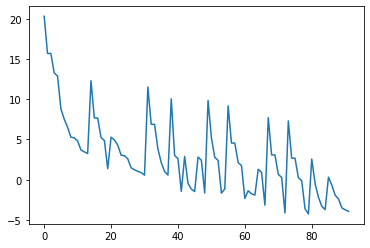

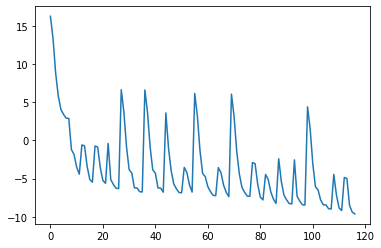

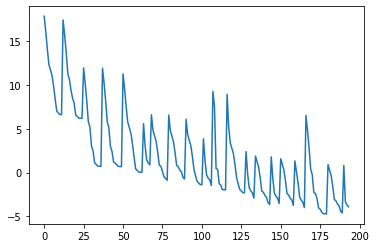

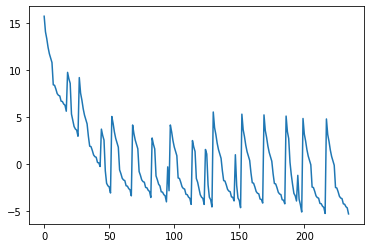

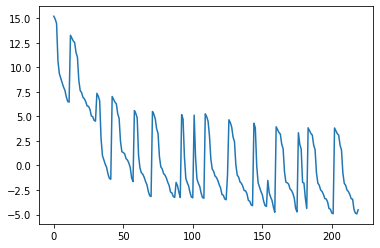

In [608]:
import matplotlib.pyplot as plt
for scores in score_list[:5]:
    plt.plot(scores)
    plt.show()

In [609]:
'''
import matplotlib.pyplot as plt
for scores in score_list[:5]:
    plt.plot(scores)
    plt.show()
'''

'\nimport matplotlib.pyplot as plt\nfor scores in score_list[:5]:\n    plt.plot(scores)\n    plt.show()\n'

Then we can load the metric from the datasets library.

In [61]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

Then we can call compute on it. We just need to format predictions and labels a bit as it expects a list of dictionaries and not one big dictionary. In the case of squad_v2, we also have to set a `no_answer_probability` argument (which we set to 0.0 here as we have already set the answer to empty if we picked it).

In [62]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in par_datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 42.857142857142854, 'f1': 48.19489334195216}

In [63]:
count = 0
wrong_ids = []
wrong_prediction = []
for prediction in formatted_predictions:
    # 'id', 'prediction_text'
    id = prediction['id']
    prediction_text = prediction['prediction_text']
    index = par_datasets['validation']['id'].index(id)
    answers = par_datasets['validation'][index]["answers"]
    if prediction_text not in answers['text']:
        count += 1
        wrong_ids.append(id)
        wrong_prediction.append(prediction_text)
    
print(100* (count / len(formatted_predictions)))


57.14285714285714


In [64]:
wrong_problem = []
for id in wrong_ids:
    index = par_datasets["validation"]['id'].index(id)
    wrong_problem.append(par_datasets['validation'][index])

with open('para_wrong_problem.pkl','wb') as f:
    pickle.dump(wrong_problem,f)

with open('para_wrong_prediction.pkl','wb') as f:
    pickle.dump(wrong_prediction,f)


In [498]:
wrong_prediction

['84 hours',
 '1024',
 '512',
 '10 million',
 '322',
 'tens of thousands',
 'smallest',
 'William Morris',
 'most of Eurasia',
 'Richard E. Grant',
 'United States',
 'Seeztal valley',
 '£42,090',
 'under £3,000 to £21,000',
 '2005',
 'Seattle Seahawks',
 '49.6%',
 'two million by 1562, concentrated mainly in the southern and central parts of France, about one-eighth',
 '1971',
 '1999',
 '3 January 1521',
 'near the surface',
 'Omeo',
 'Alvaro Martin and Raul Allegre',
 'Italy',
 'Mongol Empire',
 'NBC and Fox',
 "Chen's theorem",
 'Thomas Edison and Nikola Tesla',
 'Roone Arledge',
 'Serge Chermayeff',
 'Murray Gold and Ben Foster']

In [499]:
wrong_problem

[{'id': '763aba9adb7b4b27bff2ba0e',
  'title': 'Title_2',
  'context': 'During his second year of study at Graz, Tesla developed a passion for (and became very proficient at) billiards, chess and card-playing, sometimes spending more than 48 hours in a stretch at a gaming table.:43, 301 On one occasion at his laboratory, Tesla worked for a period of 84 hours without sleep or rest.:208 Kenneth Swezey, a journalist whom Tesla had befriended, confirmed that Tesla rarely slept. Swezey recalled one morning when Tesla called him at 3 a.m.: "I was sleeping in my room like one dead ... Suddenly, the telephone ring awakened me ... [Tesla] spoke animatedly, with pauses, [as he] ... work[ed] out a problem, comparing one theory to another, commenting; and when he felt he had arrived at the solution, he suddenly closed the telephone."',
  'question': 'How long would Tesla spend gambling sometimes without sleep or rest?',
  'answers': {'answer_start': [157, 167, 167],
   'text': ['more than 48 hours

You can now upload the result of the training to the Hub, just execute this instruction:

In [500]:
trainer.push_to_hub()

Saving model checkpoint to distilbert-base-uncased-finetuned-squad
Configuration saved in distilbert-base-uncased-finetuned-squad/config.json
Model weights saved in distilbert-base-uncased-finetuned-squad/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained("sgugger/my-awesome-model")
```